# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 11.6 s, sys: 572 ms, total: 12.2 s
Wall time: 12 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = 1
tpu_cores = None
precision=32

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [6]:
torch.cuda.is_available()

True

# Here goes all the stuff that we change from dataset to dataset

In [7]:
from os import path

In [8]:
dataset_dir = '../data/zeisel/'
model_save_path = '../data/zeisel/models/'
viz_save_path = '../data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [9]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [10]:
adata.obs

,names0,names1,labels0,labels1
0,interneurons,Int10,3,12
1,interneurons,Int10,3,12
2,interneurons,Int6,3,23
3,interneurons,Int10,3,12
4,interneurons,Int9,3,26
...,...,...,...,...
3000,endothelial-mural,Peric,2,35
3001,endothelial-mural,Vsmc,2,48
3002,endothelial-mural,Vsmc,2,48
3003,endothelial-mural,Vsmc,2,48


In [11]:
adata.shape

(3005, 4000)

In [12]:
np.apply_along_axis(np.mean, 0, adata.X)

array([5.07780e-09, 4.06224e-08, 0.00000e+00, ..., 4.06224e-08,
       3.04668e-08, 0.00000e+00], dtype=float32)

In [13]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.9996673, 0.9996672, 0.9996674, ..., 0.9996672, 0.9996674,
       0.9996673], dtype=float32)

In [14]:
X = adata.X.copy()
adata.obs['names']=adata.obs['names0']
adata.obs['annotation'] = adata.obs['names0']
labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [15]:
input_size = X.shape[1]
y

array([2, 2, 2, ..., 1, 1, 1])

# Set Up Models

## Baseline

In [16]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)


CPU times: user 7min 8s, sys: 4.57 s, total: 7min 13s
Wall time: 7min 2s


## Train Smash Random Forest





In [17]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

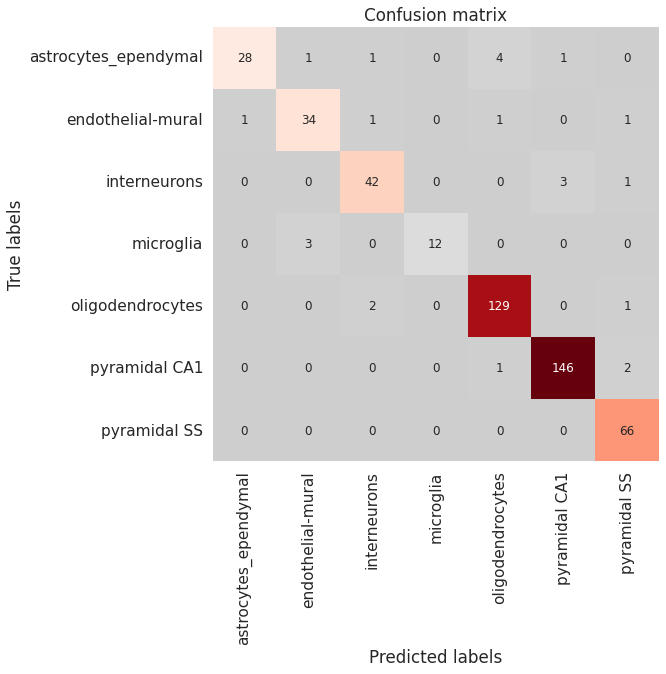

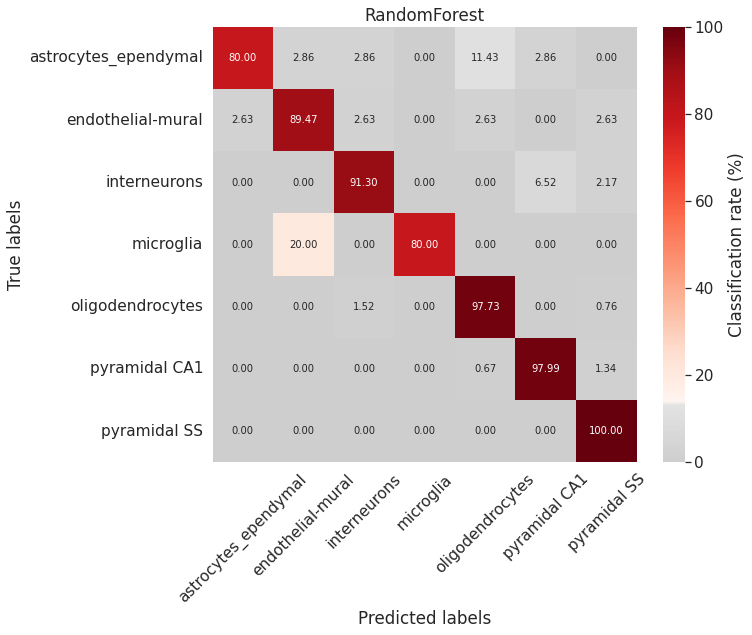

Accuracy: 0.9501039501039501: Misclassification: 0.0498960498960499
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.80      0.88        35
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       0.91      0.91      0.91        46
           microglia       1.00      0.80      0.89        15
    oligodendrocytes       0.96      0.98      0.97       132
       pyramidal CA1       0.97      0.98      0.98       149
        pyramidal SS       0.93      1.00      0.96        66

            accuracy                           0.95       481
           macro avg       0.95      0.91      0.93       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

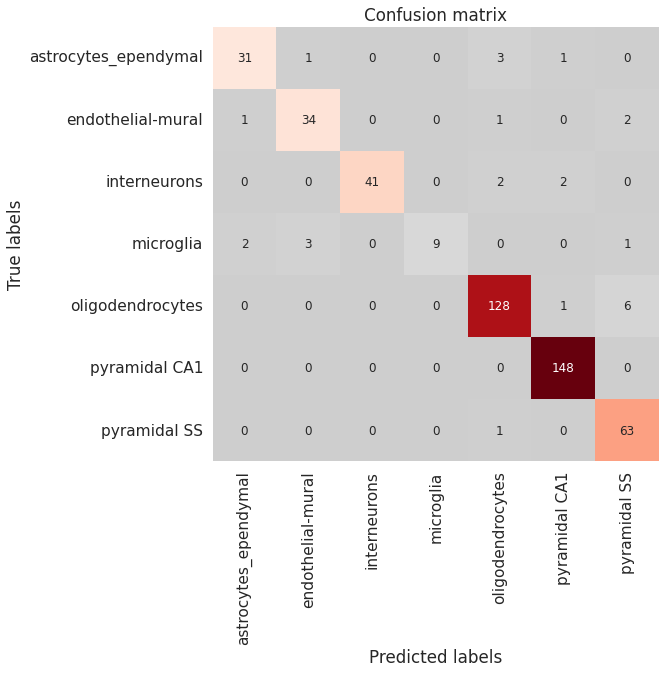

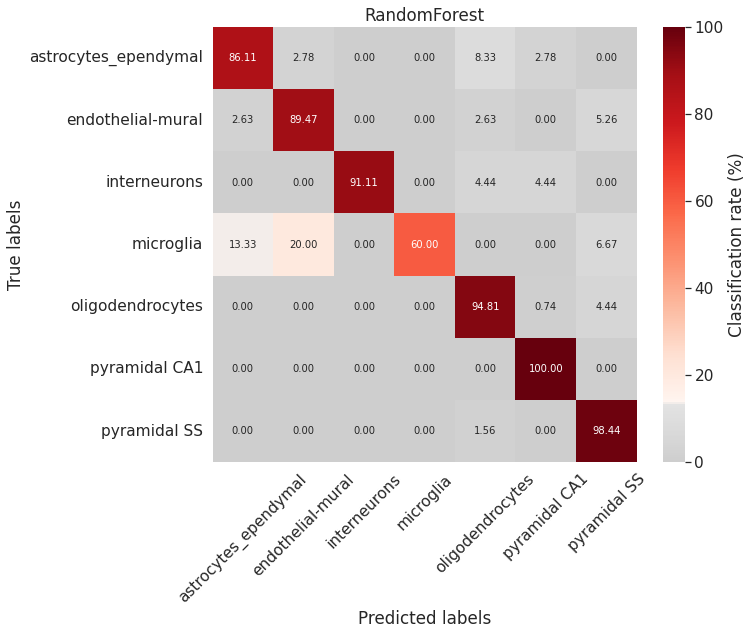

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

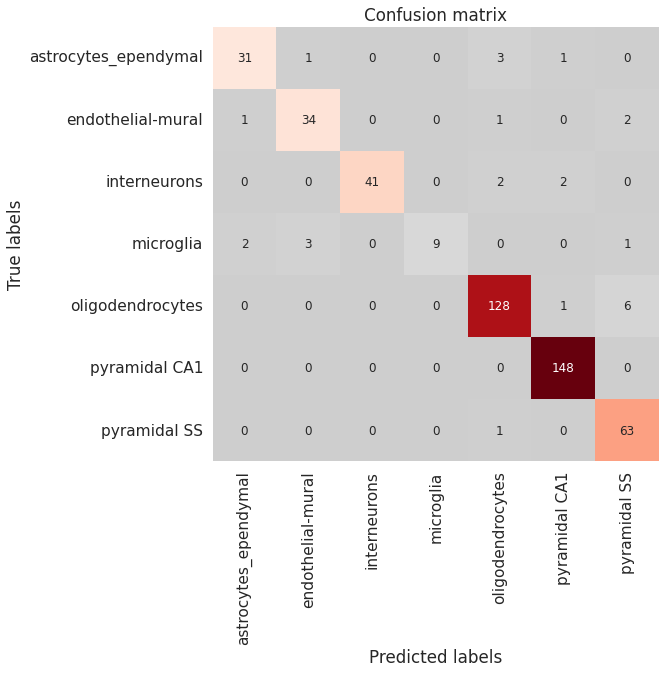

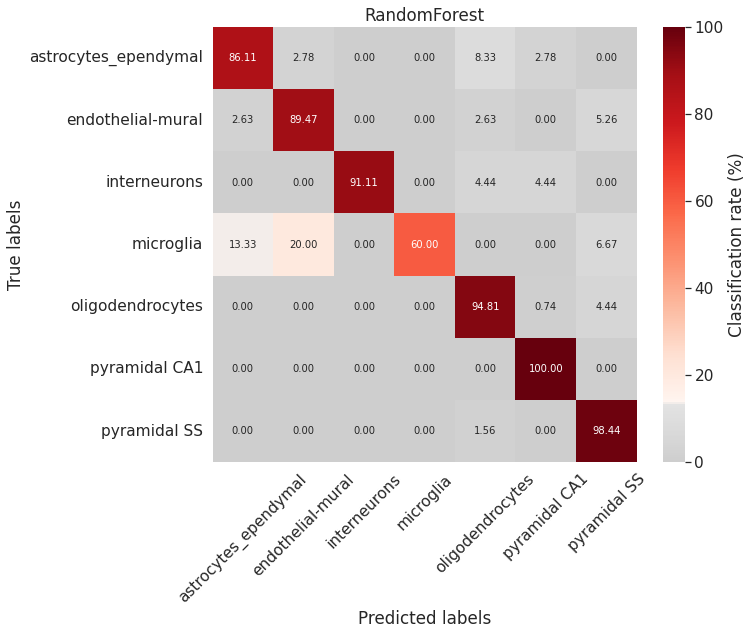

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

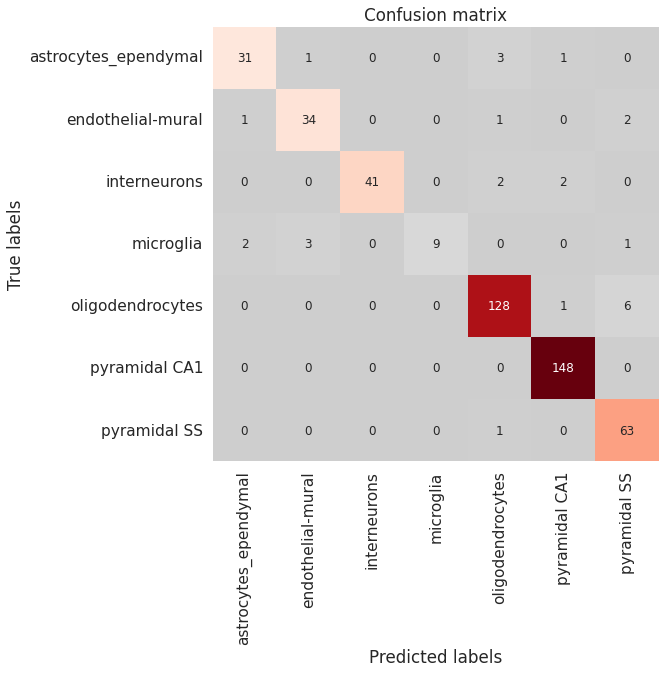

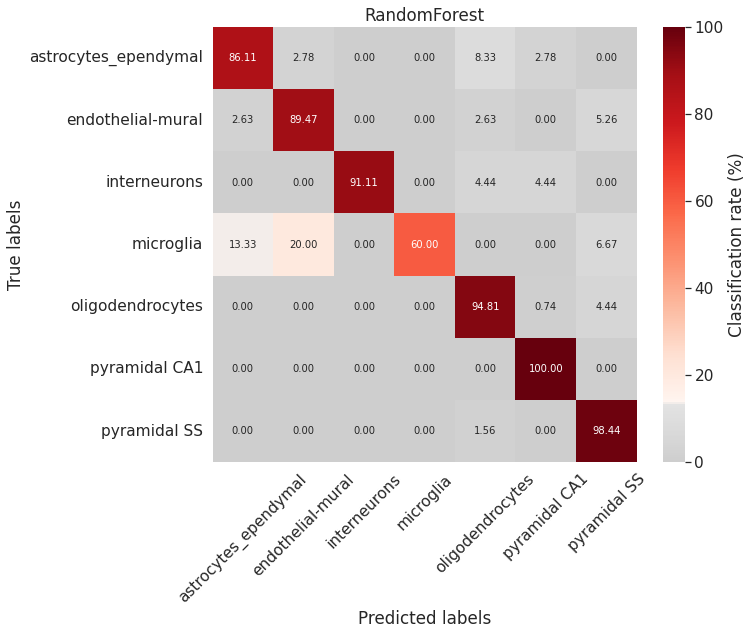

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

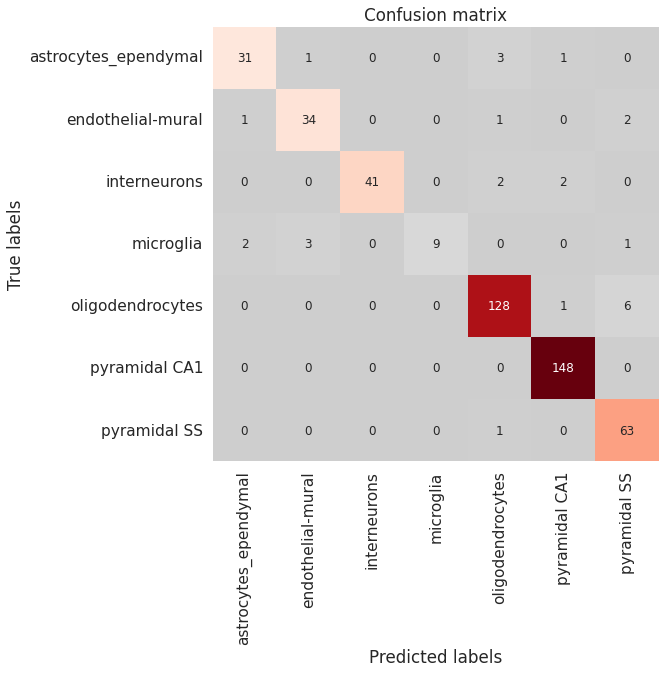

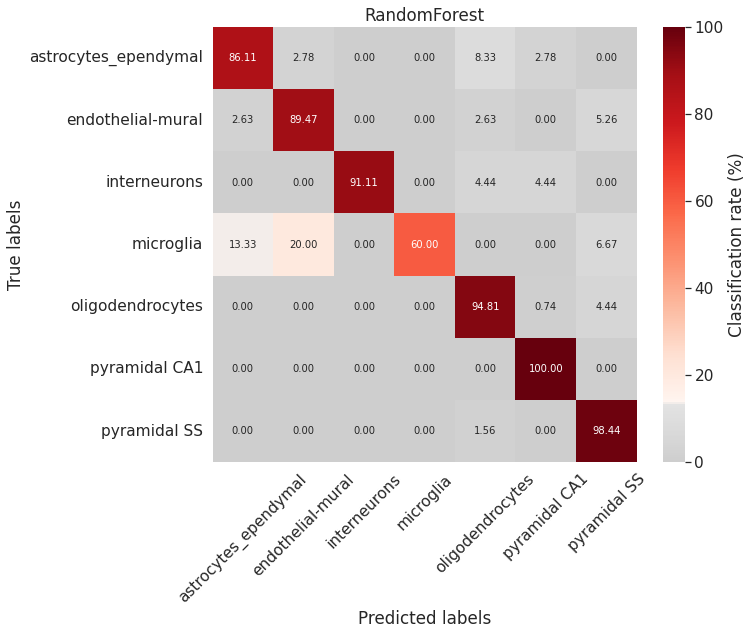

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

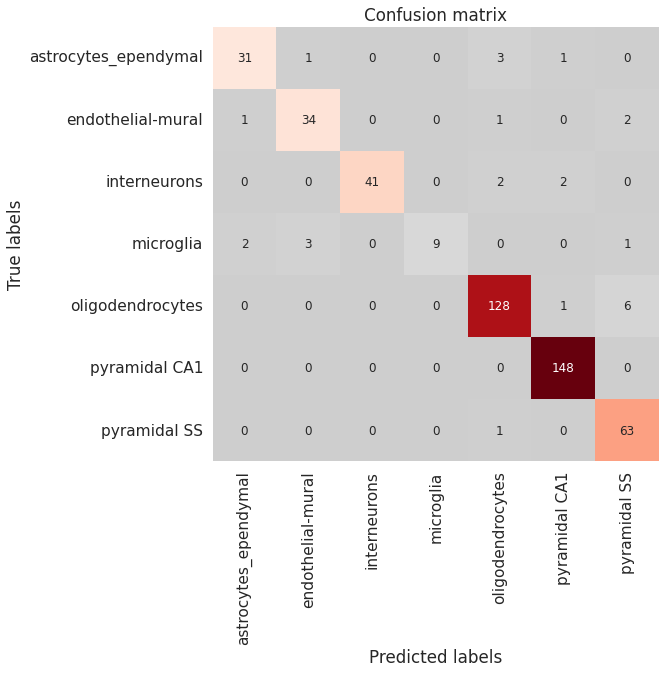

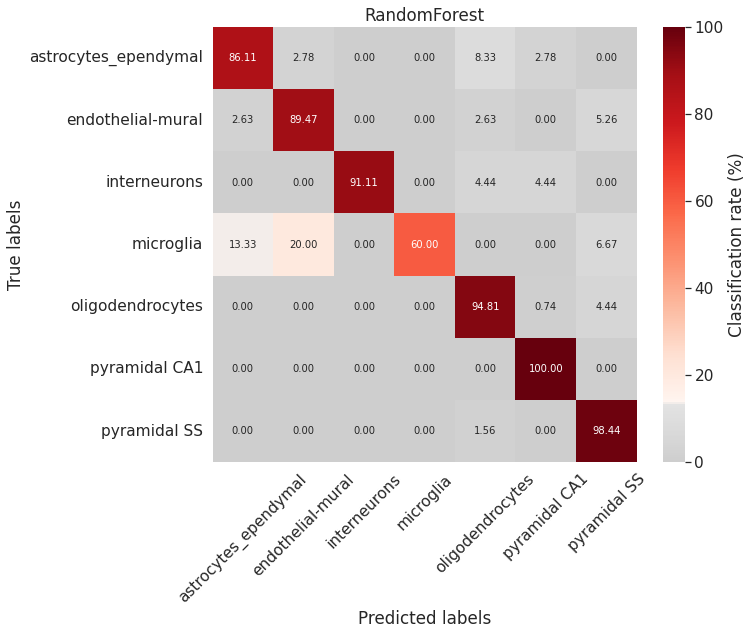

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

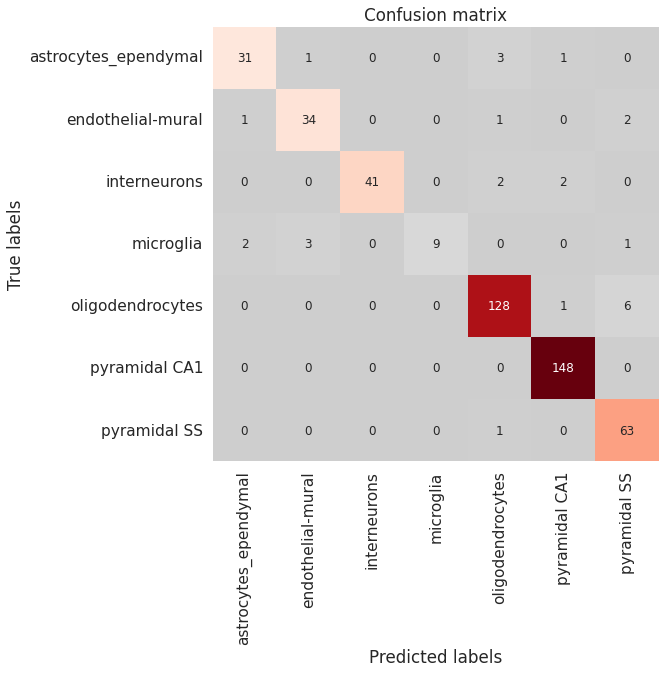

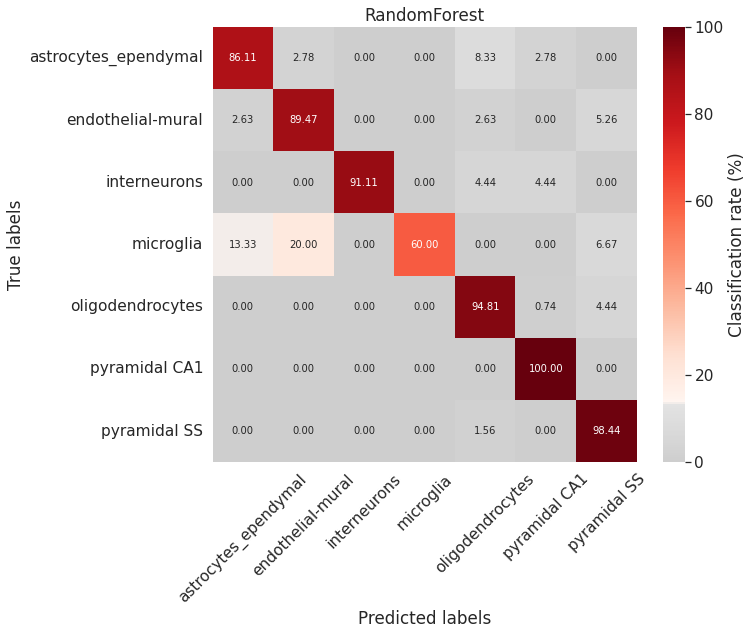

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

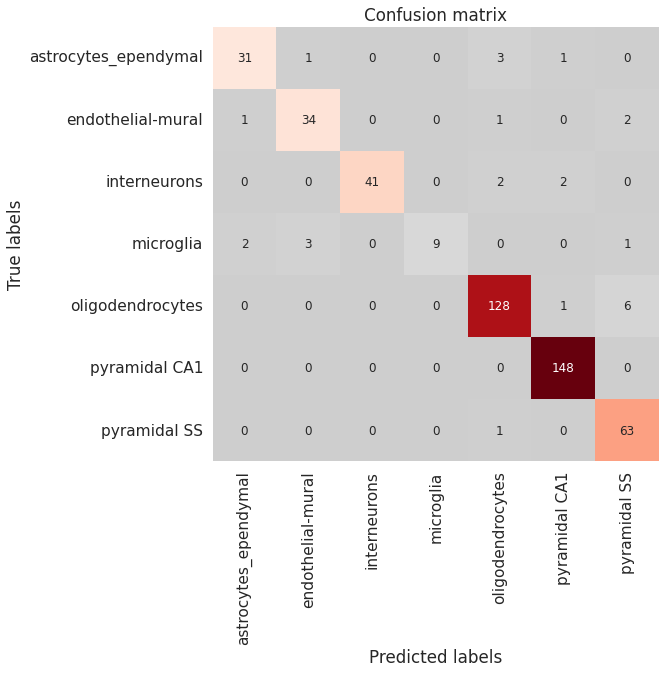

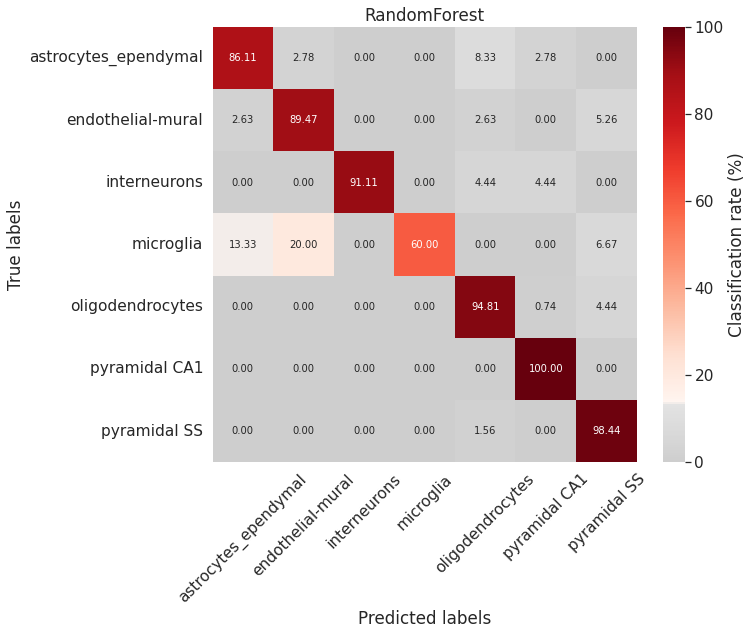

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

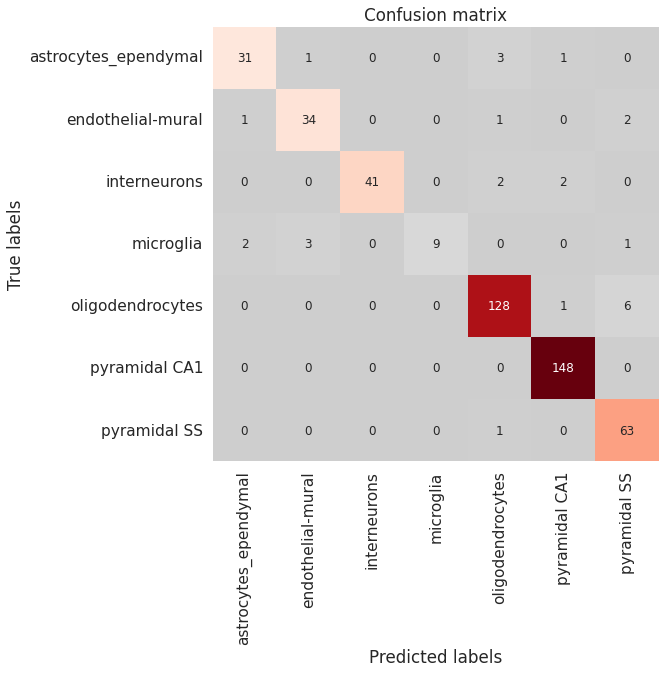

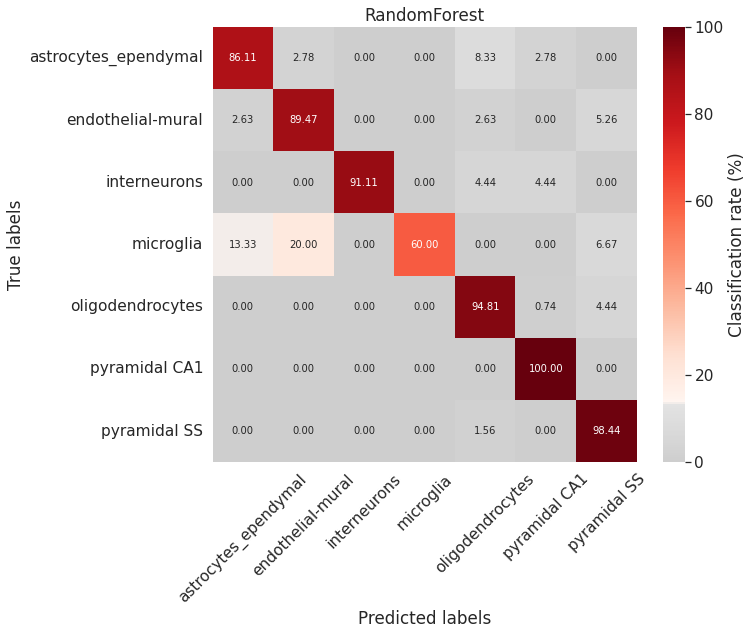

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

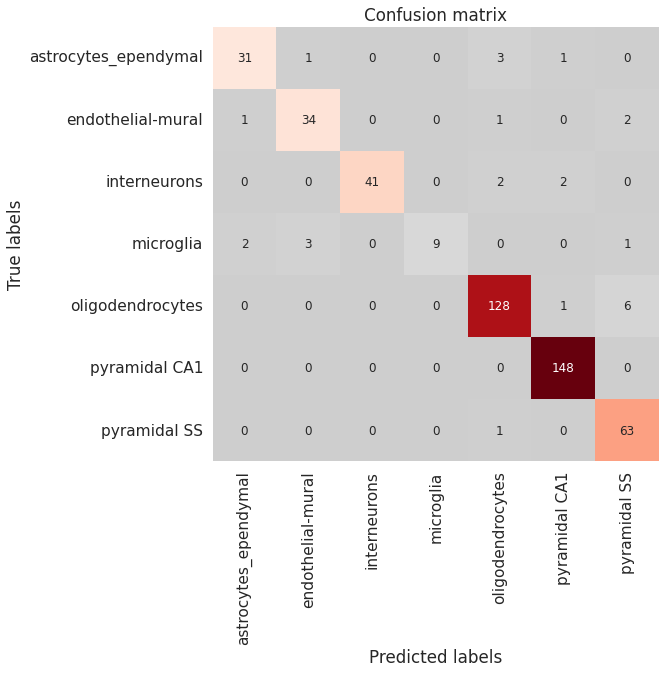

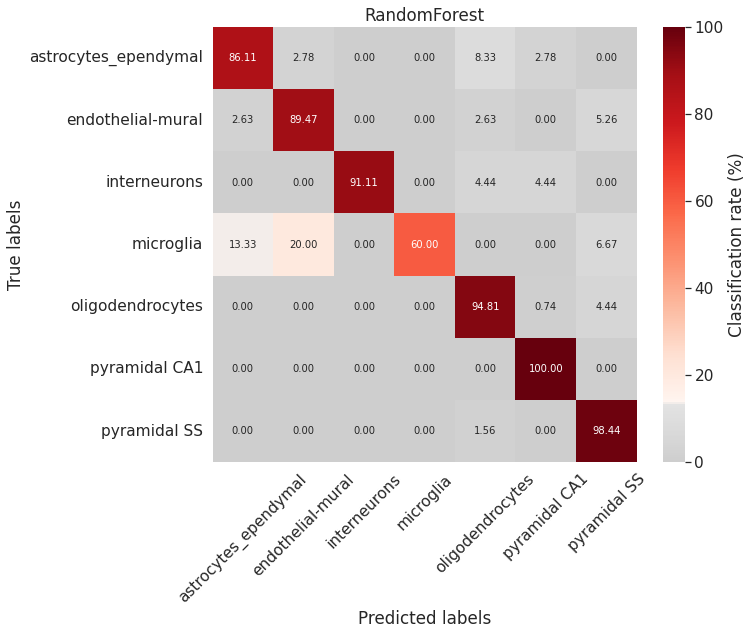

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        36
   endothelial-mural       0.89      0.89      0.89        38
        interneurons       1.00      0.91      0.95        45
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.95      0.95      0.95       135
       pyramidal CA1       0.97      1.00      0.99       148
        pyramidal SS       0.88      0.98      0.93        64

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.95      0.94      0.94       481

CPU times: user 5min 57s, sys: 5.65 s, total: 6min 3s
Wall time: 6min 3s


In [18]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

25/25 [==============================] - 0s 13ms/step - loss: 0.6973 - accuracy: 0.9235 - auc: 0.9935 - precision: 0.9966 - recall: 0.4825 - val_loss: 0.7009 - val_accuracy: 0.9318 - val_auc: 0.9946 - val_precision: 0.9944 - val_recall: 0.5890

Epoch 00018: val_loss improved from 0.75248 to 0.70092, saving model to weights/best_model_annotation.h5
Epoch 19/100
25/25 [==============================] - 0s 8ms/step - loss: 0.6578 - accuracy: 0.9214 - auc: 0.9933 - precision: 0.9976 - recall: 0.5237 - val_loss: 0.6815 - val_accuracy: 0.9351 - val_auc: 0.9950 - val_precision: 0.9974 - val_recall: 0.6439

Epoch 00019: val_loss improved from 0.70092 to 0.68145, saving model to weights/best_model_annotation.h5
Epoch 20/100
25/25 [==============================] - 0s 9ms/step - loss: 0.6189 - accuracy: 0.9355 - auc: 0.9949 - precision: 0.9950 - recall: 0.5745 - val_loss: 0.6464 - val_accuracy: 0.9418 - val_auc: 0.9943 - val_precision: 0.9930 - val_recall: 0.7038

Epoch 00020: val_loss improved 

25/25 [==============================] - 0s 7ms/step - loss: 0.2728 - accuracy: 0.9663 - auc: 0.9991 - precision: 0.9923 - recall: 0.9072 - val_loss: 0.3307 - val_accuracy: 0.9451 - val_auc: 0.9957 - val_precision: 0.9750 - val_recall: 0.9101

Epoch 00041: val_loss improved from 0.34421 to 0.33067, saving model to weights/best_model_annotation.h5
Epoch 42/100
25/25 [==============================] - 0s 9ms/step - loss: 0.2451 - accuracy: 0.9813 - auc: 0.9993 - precision: 0.9946 - recall: 0.9260 - val_loss: 0.3222 - val_accuracy: 0.9451 - val_auc: 0.9959 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00042: val_loss improved from 0.33067 to 0.32221, saving model to weights/best_model_annotation.h5
Epoch 43/100
25/25 [==============================] - 0s 9ms/step - loss: 0.2296 - accuracy: 0.9813 - auc: 0.9996 - precision: 0.9952 - recall: 0.9430 - val_loss: 0.3513 - val_accuracy: 0.9368 - val_auc: 0.9952 - val_precision: 0.9690 - val_recall: 0.8835

Epoch 00043: val_loss did not im


Epoch 00065: val_loss improved from 0.20958 to 0.20130, saving model to weights/best_model_annotation.h5
Epoch 66/100
25/25 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.9900 - auc: 0.9998 - precision: 0.9953 - recall: 0.9763 - val_loss: 0.2105 - val_accuracy: 0.9501 - val_auc: 0.9968 - val_precision: 0.9656 - val_recall: 0.9351

Epoch 00066: val_loss did not improve from 0.20130
Epoch 67/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2234 - accuracy: 0.9667 - auc: 0.9990 - precision: 0.9864 - recall: 0.9322 - val_loss: 0.2655 - val_accuracy: 0.9434 - val_auc: 0.9966 - val_precision: 0.9715 - val_recall: 0.9068

Epoch 00067: val_loss did not improve from 0.20130
Epoch 68/100
25/25 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9804 - auc: 0.9995 - precision: 0.9901 - recall: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9501 - val_auc: 0.9972 - val_precision: 0.9642 - val_recall: 0.9401

Epoch 00068: val_los

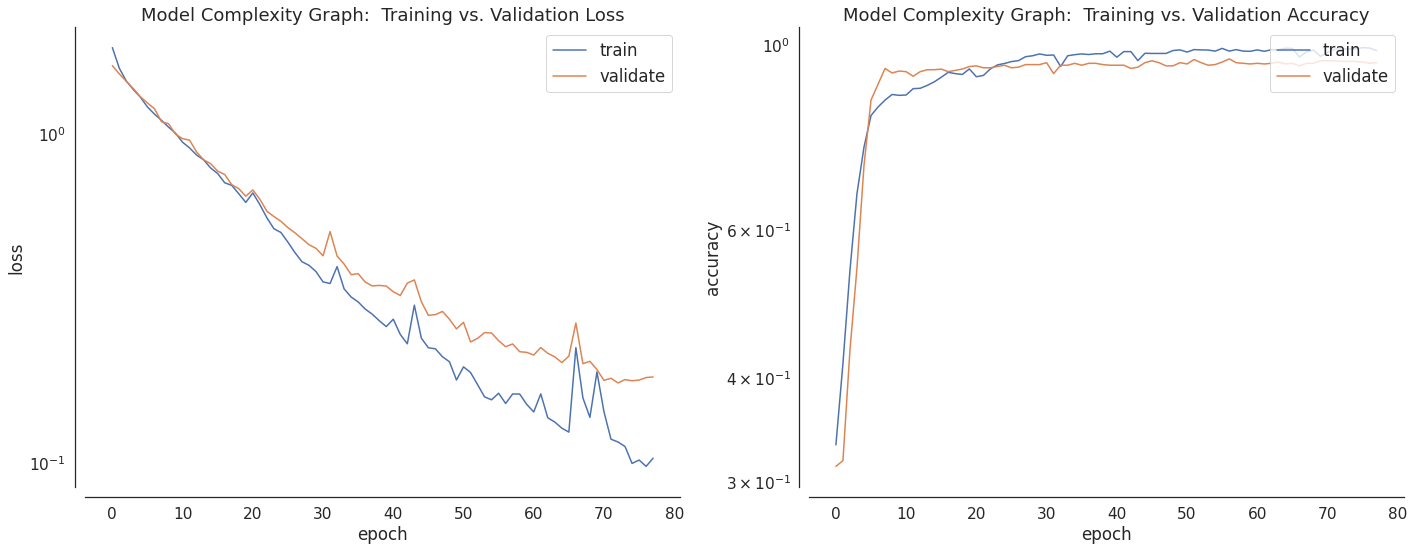

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

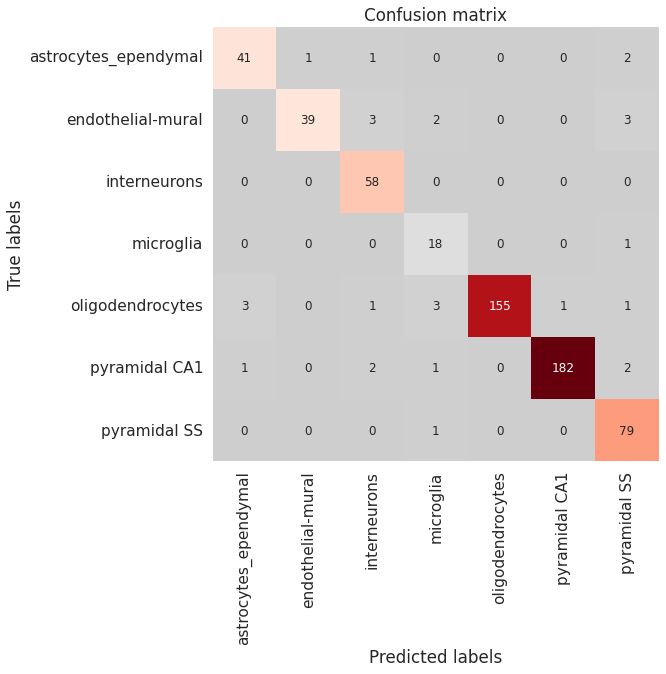

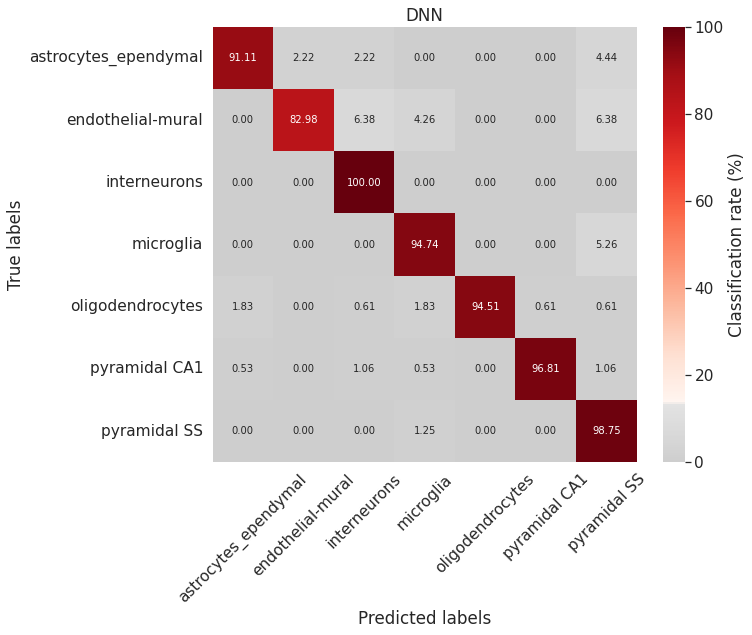

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.91      0.91        45
   endothelial-mural       0.97      0.83      0.90        47
        interneurons       0.89      1.00      0.94        58
           microglia       0.72      0.95      0.82        19
    oligodendrocytes       1.00      0.95      0.97       164
       pyramidal CA1       0.99      0.97      0.98       188
        pyramidal SS       0.90      0.99      0.94        80

            accuracy                           0.95       601
           macro avg       0.91      0.94      0.92       601
        weighted avg       0.96      0.95      0.95       601



ValueError: Cannot assign to variable dense/kernel:0 due to variable shape (4000, 32) and value shape (3113, 32) are incompatible

In [19]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

## Train RankCorr

In [20]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

Excess Length of markers
53
Excess Length of markers
55
Excess Length of markers
55
Excess Length of markers
54
Excess Length of markers
54
Excess Length of markers
52
Excess Length of markers
52
Excess Length of markers
56
Excess Length of markers
52
Excess Length of markers
58


## Train L1 VAE

In [21]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the

OSError: [Errno 12] Cannot allocate memory

## Train Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

## Train MarkerMap Unsupervised

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

## Train MarkerMap Supervised

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

## MakerMap Mixed

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

## LassoNet



In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from functools import partial
from lassonet import plot_path

In [ ]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier()
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

## Get Model Metrics from KNNs Classifiers

The above just generates metrics for the Random Forests.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')


In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

# Results and Visualizations

## Accuracies and F1

In [ ]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

## Confusion Matrices

k = 50

### All Marker Baseline

In [ ]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### MarkerMap Unsupervised

In [ ]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


In [ ]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

## MarkerMap Mixed Supervision

In [ ]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

In [ ]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')